In [46]:
import os
from matplotlib.pylab import plt

In [47]:
losses = []
losses_avg = []
fire_aps = []
fire_confusions = []
smoke_aps = []
smoke_confusions = []
precisions = []
recalls = []
f1scores = []
confusions = []
iou_avgs = []
maps = []
with open(os.path.abspath(os.path.join(os.getcwd(), '..', 'darknet', 'log.txt'))) as log_file:
    current_iteration = 1
    for line in log_file:
        if line.startswith(f' {current_iteration}: '):
            values = line[line.index(':') + 1:].split(',')[:2]
            losses.append(float(values[0].strip()))
            losses_avg.append(float(values[1].strip().split(' ')[0]))
            current_iteration += 1
        elif line.startswith('class_id = '):
            ap_index = line.index('ap = ') + 5
            percent_index = line.index('%')
            ap = float(line[ap_index:percent_index]) / 100

            tp_index = line.index('TP = ') + 5
            comma_index = line.rindex(',')
            tp = int(line[tp_index:comma_index])
            fp_index = line.rindex('FP = ') + 5
            fp = int(line[fp_index:line.rindex(')')])

            if line.startswith('class_id = 0, name = fire, '):
                fire_aps.append((current_iteration, ap))
                fire_confusions.append((current_iteration, (tp, fp)))
            elif line.startswith('class_id = 1, name = smoke, '):
                smoke_aps.append((current_iteration, ap))
                smoke_confusions.append((current_iteration, (tp, fp)))
        elif line.startswith(' for conf_thresh = 0.25, precision'):
            values = line.split(',')
            precisions.append((current_iteration, float(values[1][values[1].rindex(' ') + 1:])))
            recalls.append((current_iteration, float(values[2][values[2].rindex(' ') + 1:])))
            f1scores.append((current_iteration, float(values[3][values[3].strip().rindex(' ') + 1:])))
        elif line.startswith(' for conf_thresh = 0.25, TP'):
            values = line.split(',')
            tp = int(values[1][values[1].rindex(' ') + 1:])
            fp = int(values[2][values[2].rindex(' ') + 1:])
            fn = int(values[3][values[3].rindex(' ') + 1:])
            confusions.append((current_iteration, (tp, fp, fn)))
            iou_avgs.append((current_iteration, float(values[4][values[4].index('=') + 1:values[4].rindex('%')].strip()) / 100))
        elif line.startswith(' mean_average_precision'):
            maps.append((current_iteration, float(line[line.rindex('=') + 1:].strip())))

del line, log_file
del current_iteration, values
del ap_index, percent_index, ap, tp_index, comma_index, fp_index
del tp, fp, fn

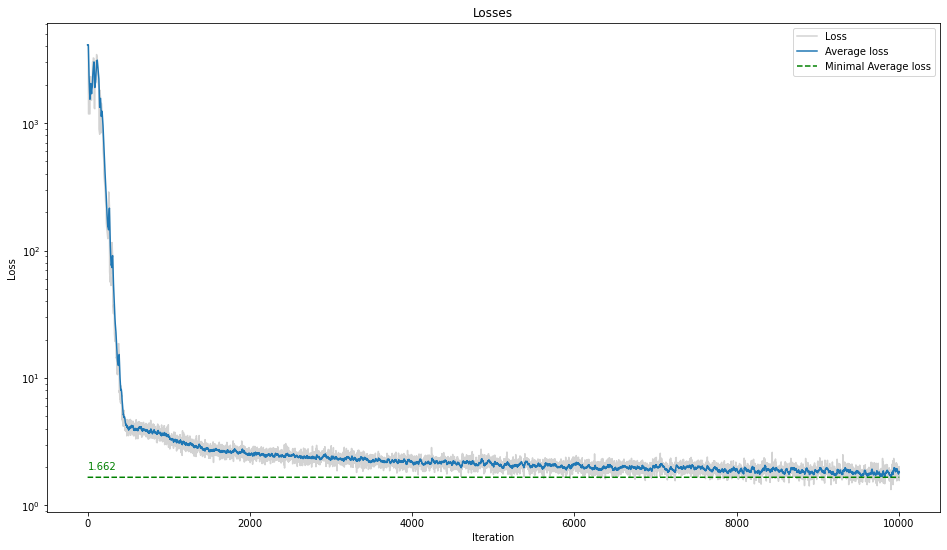

In [48]:
plt.figure(figsize=(16, 9))
plt.title('Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')

plt.plot(range(len(losses)), losses, color='lightgray', label='Loss')
plt.plot(range(len(losses)), losses_avg, label='Average loss')

minimal_average_loss = min(losses_avg)
plt.plot(range(len(losses_avg)), [minimal_average_loss] * len(losses_avg), linestyle='--', color='green', label='Minimal Average loss')
plt.text(0, minimal_average_loss + 0.25, f'{minimal_average_loss:.4}', color='green')

plt.legend(loc='best')
plt.show()

del minimal_average_loss
del losses, losses_avg

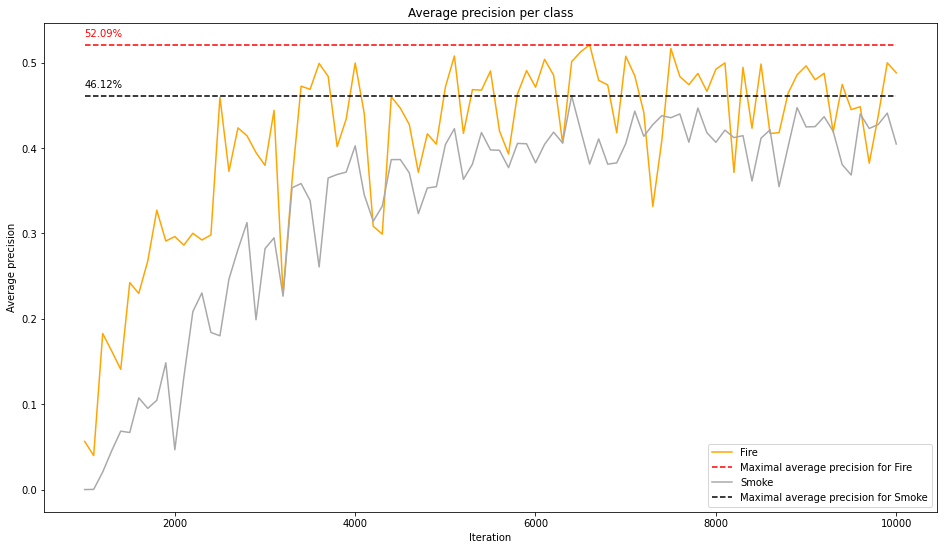

In [49]:
plt.figure(figsize=(16, 9))
plt.title('Average precision per class')
plt.xlabel('Iteration')
plt.ylabel('Average precision')

fire_ap_iterations = [fire_ap[0] for fire_ap in fire_aps]
fire_ap_values = [fire_ap[1] for fire_ap in fire_aps]
maximal_fire_ap = max(fire_ap_values)
plt.plot(fire_ap_iterations, fire_ap_values, color='orange', label='Fire')
plt.plot(fire_ap_iterations, [maximal_fire_ap] * len(fire_ap_iterations), linestyle='--', color='red', label='Maximal average precision for Fire')
plt.text(fire_ap_iterations[0], maximal_fire_ap + 0.01, f'{maximal_fire_ap:.2%}', color='red')

smoke_ap_iterations = [smoke_ap[0] for smoke_ap in smoke_aps]
smoke_ap_values = [smoke_ap[1] for smoke_ap in smoke_aps]
maximal_smoke_ap = max(smoke_ap_values)
plt.plot(smoke_ap_iterations, smoke_ap_values, color='darkgray', label='Smoke')
plt.plot(smoke_ap_iterations, [maximal_smoke_ap] * len(smoke_ap_iterations), linestyle='--', color='black', label='Maximal average precision for Smoke')
plt.text(smoke_ap_iterations[0], maximal_smoke_ap + 0.01, f'{maximal_smoke_ap:.2%}', color='black')

plt.legend(loc='best')
plt.show()

del fire_ap_iterations, fire_ap_values, maximal_fire_ap
del smoke_ap_iterations, smoke_ap_values, maximal_smoke_ap
del fire_aps, smoke_aps

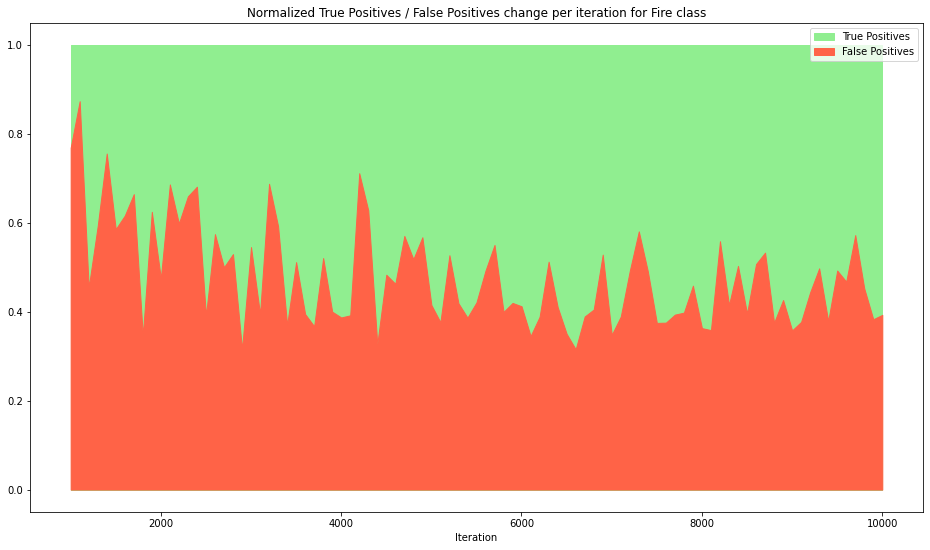

In [50]:
plt.figure(figsize=(16, 9))
plt.title('Normalized True Positives / False Positives change per iteration for Fire class')
plt.xlabel('Iteration')

fire_confusion_iterations = [elem[0] for elem in fire_confusions]
total = [elem[1][0] + elem[1][1] for elem in fire_confusions]
fire_confusion_tps = [(fire_confusions[i][1][0] + fire_confusions[i][1][1]) / total[i] for i in range(len(fire_confusions))]
fire_confusion_fps = [(fire_confusions[i][1][1]) / total[i] for i in range(len(fire_confusions))]

plt.fill_between(fire_confusion_iterations, 0, fire_confusion_tps, color='lightgreen', label='True Positives')
plt.fill_between(fire_confusion_iterations, 0, fire_confusion_fps, color='tomato', label='False Positives')
plt.legend(loc='best')

plt.show()

del fire_confusion_iterations, total, fire_confusion_tps, fire_confusion_fps
del fire_confusions

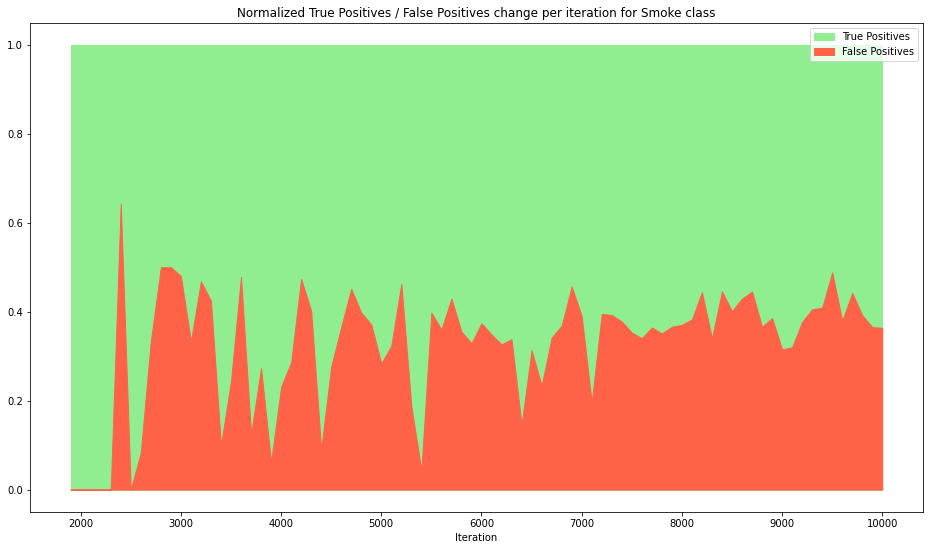

In [51]:
plt.figure(figsize=(16, 9))
plt.title('Normalized True Positives / False Positives change per iteration for Smoke class')
plt.xlabel('Iteration')

smoke_confusions_indices = [i for i in range(len(smoke_confusions)) if smoke_confusions[i][1][0] + smoke_confusions[i][1][1] != 0]
smoke_confusion_iterations = [smoke_confusions[i][0] for i in smoke_confusions_indices]
total = [smoke_confusions[i][1][0] + smoke_confusions[i][1][1] for i in smoke_confusions_indices]
smoke_confusion_tps = [(smoke_confusions[smoke_confusions_indices[i]][1][0] + smoke_confusions[smoke_confusions_indices[i]][1][1]) / total[i] for i in range(len(smoke_confusions_indices))]
smoke_confusion_fps = [(smoke_confusions[smoke_confusions_indices[i]][1][1]) / total[i] for i in range(len(smoke_confusions_indices))]

plt.fill_between(smoke_confusion_iterations, 0, smoke_confusion_tps, color='lightgreen', interpolate=True, label='True Positives')
plt.fill_between(smoke_confusion_iterations, 0, smoke_confusion_fps, color='tomato', interpolate=True, label='False Positives')
plt.legend(loc='best')

plt.show()

del smoke_confusions_indices, smoke_confusion_iterations, total, smoke_confusion_tps, smoke_confusion_fps
del smoke_confusions

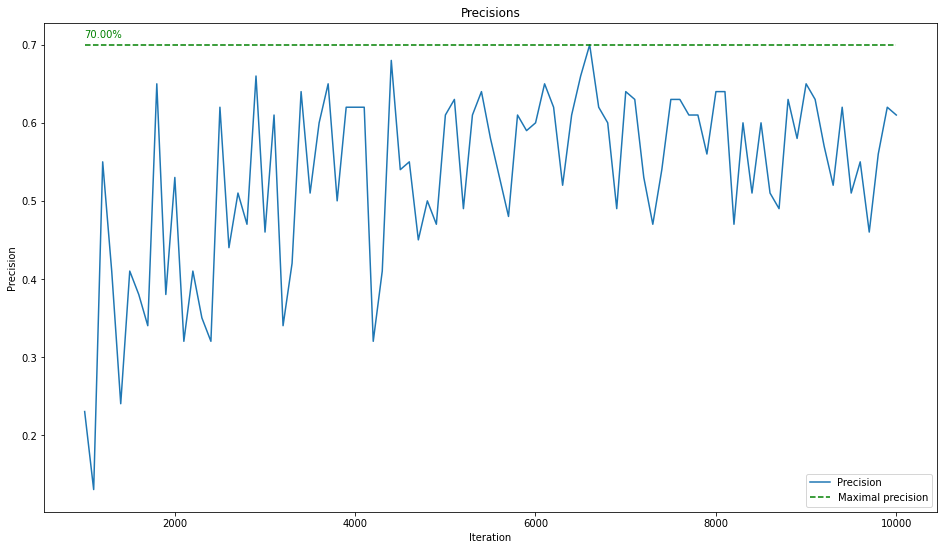

In [52]:
plt.figure(figsize=(16, 9))
plt.title('Precisions')
plt.xlabel('Iteration')
plt.ylabel('Precision')

iterations = [elem[0] for elem in precisions]
values = [elem[1] for elem in precisions]
plt.plot(iterations, values, label='Precision')

maximal_precision = max(values)
plt.plot(iterations, [maximal_precision] * len(iterations), linestyle='--', color='green', label='Maximal precision')
plt.text(iterations[0], maximal_precision + 0.01, f'{maximal_precision:.2%}', color='green')

plt.legend(loc='best')
plt.show()

del iterations, values, maximal_precision
del precisions

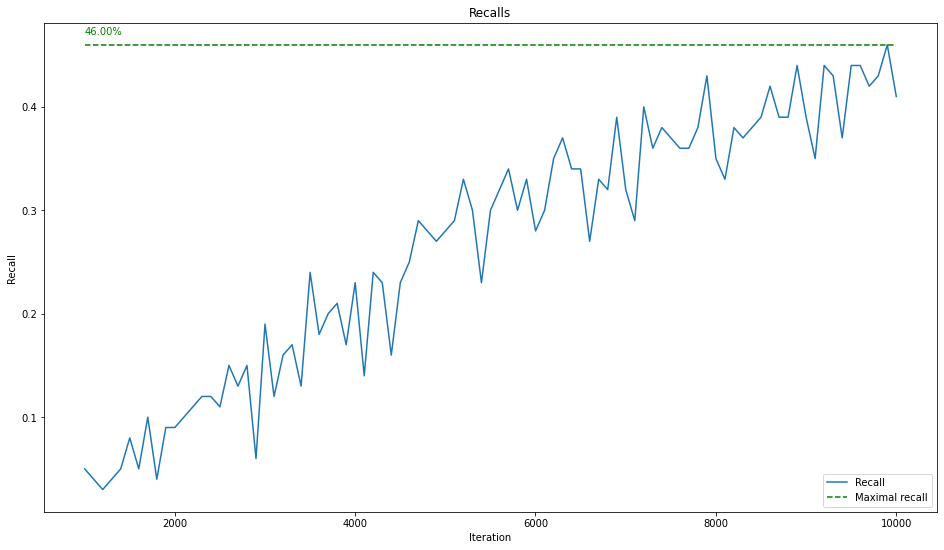

In [53]:
plt.figure(figsize=(16, 9))
plt.title('Recalls')
plt.xlabel('Iteration')
plt.ylabel('Recall')

iterations = [elem[0] for elem in recalls]
values = [elem[1] for elem in recalls]
plt.plot(iterations, values, label='Recall')

maximal_recall = max(values)
plt.plot(iterations, [maximal_recall] * len(iterations), linestyle='--', color='green', label='Maximal recall')
plt.text(iterations[0], maximal_recall + 0.01, f'{maximal_recall:.2%}', color='green')

plt.legend(loc='best')
plt.show()

del iterations, values, maximal_recall
del recalls

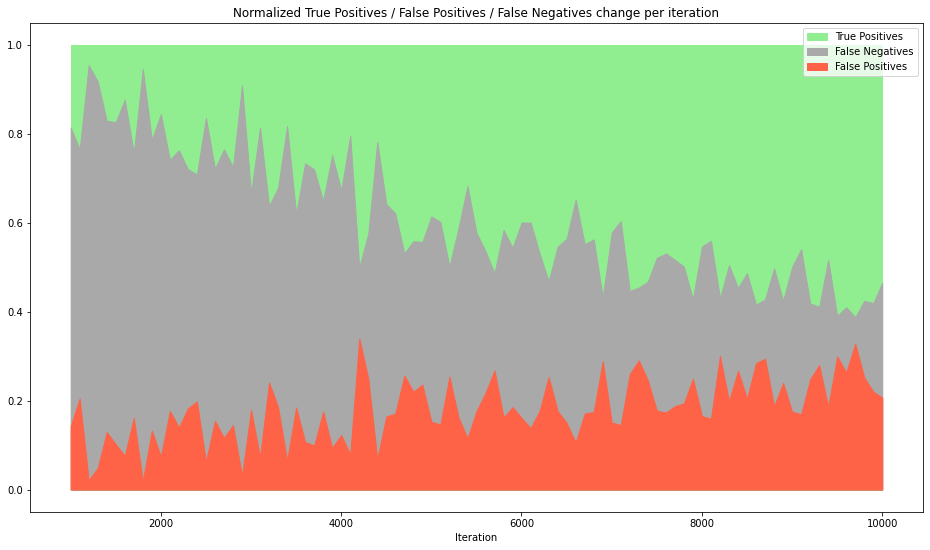

In [54]:
plt.figure(figsize=(16, 9))
plt.title('Normalized True Positives / False Positives / False Negatives change per iteration')
plt.xlabel('Iteration')

iterations = [elem[0] for elem in confusions]
total = [elem[1][0] + elem[1][1] + elem[1][2] for elem in confusions]
tps = [(confusions[i][1][0] + confusions[i][1][1] + confusions[i][1][2]) / total[i] for i in range(len(confusions))]
fps = [(confusions[i][1][1]) / total[i] for i in range(len(confusions))]
fns = [(confusions[i][1][2]) / total[i] for i in range(len(confusions))]

plt.fill_between(iterations, 0, tps, color='lightgreen', label='True Positives')
plt.fill_between(iterations, 0, fns, color='darkgray', label='False Negatives')
plt.fill_between(iterations, 0, fps, color='tomato', label='False Positives')
plt.legend(loc='best')

plt.show()

del iterations, total, tps, fps, fns
del confusions

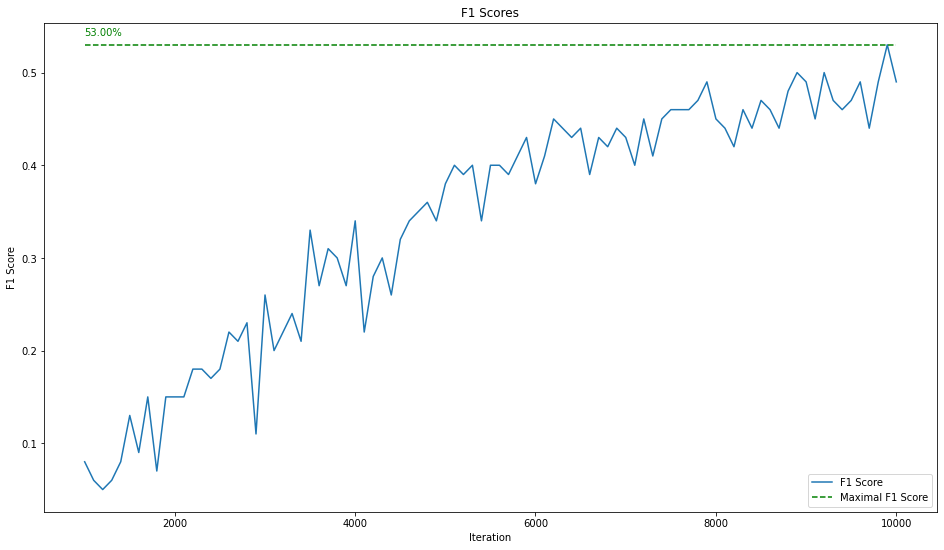

In [55]:
plt.figure(figsize=(16, 9))
plt.title('F1 Scores')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')

iterations = [elem[0] for elem in f1scores]
values = [elem[1] for elem in f1scores]
plt.plot(iterations, values, label='F1 Score')

maximal_score = max(values)
plt.plot(iterations, [maximal_score] * len(iterations), linestyle='--', color='green', label='Maximal F1 Score')
plt.text(iterations[0], maximal_score + 0.01, f'{maximal_score:.2%}', color='green')

plt.legend(loc='best')
plt.show()

del iterations, values, maximal_score
del f1scores

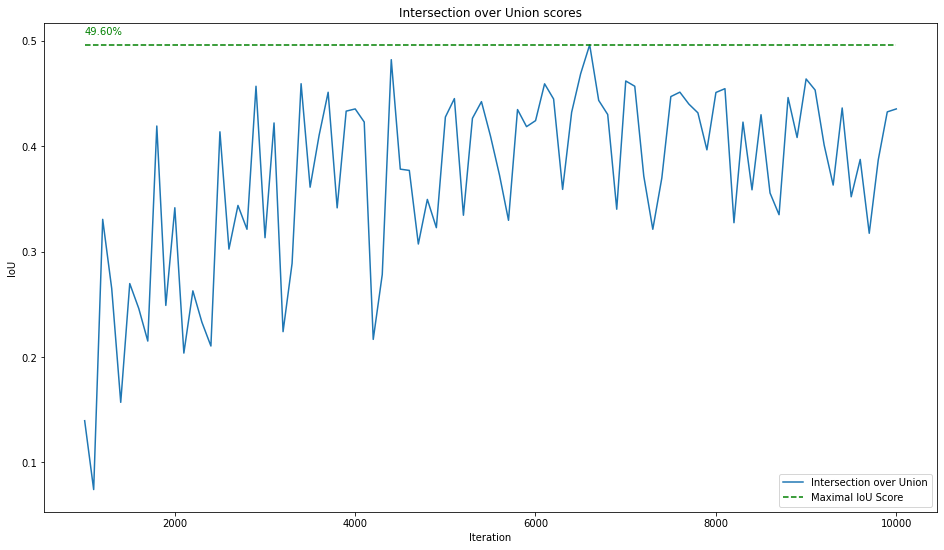

In [56]:
plt.figure(figsize=(16, 9))
plt.title('Intersection over Union scores')
plt.xlabel('Iteration')
plt.ylabel('IoU')

iterations = [elem[0] for elem in iou_avgs]
values = [elem[1] for elem in iou_avgs]
plt.plot(iterations, values, label='Intersection over Union')

maximal_IoU = max(values)
plt.plot(iterations, [maximal_IoU] * len(iterations), linestyle='--', color='green', label='Maximal IoU Score')
plt.text(iterations[0], maximal_IoU + 0.01, f'{maximal_IoU:.2%}', color='green')

plt.legend(loc='best')
plt.show()

del iterations, values, maximal_IoU
del iou_avgs

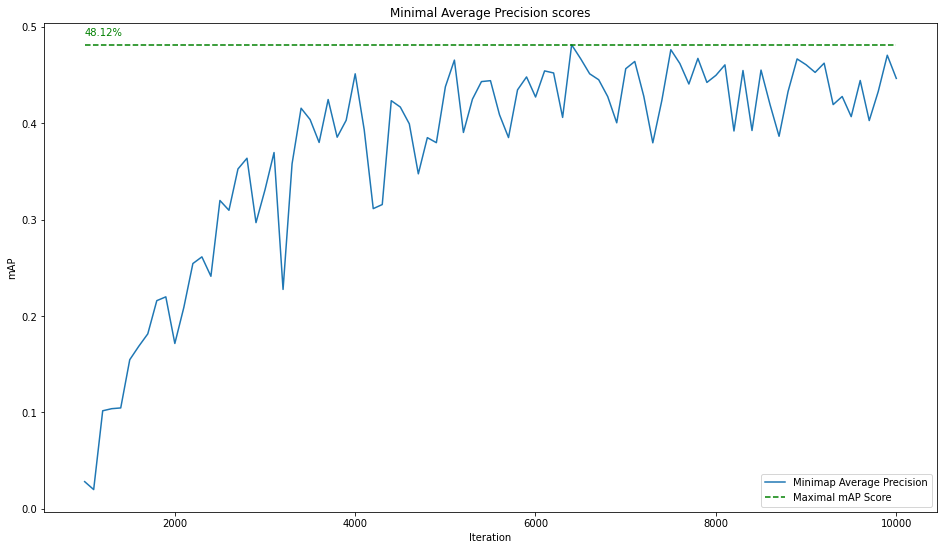

In [57]:
plt.figure(figsize=(16, 9))
plt.title('Minimal Average Precision scores')
plt.xlabel('Iteration')
plt.ylabel('mAP')

iterations = [elem[0] for elem in maps]
values = [elem[1] for elem in maps]
plt.plot(iterations, values, label='Minimap Average Precision')

maximal_IoU = max(values)
plt.plot(iterations, [maximal_IoU] * len(iterations), linestyle='--', color='green', label='Maximal mAP Score')
plt.text(iterations[0], maximal_IoU + 0.01, f'{maximal_IoU:.2%}', color='green')

plt.legend(loc='best')
plt.show()

del iterations, values, maximal_IoU
del maps